# Систем за препораки на филмови користејќи Softmax DNN
<a href="https://colab.research.google.com/github/vasetrendafilov/recommender-system/blob/main/dnn-25m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import math 
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import tensorflow as tf
import keras

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip -n ml-25m.zip

## Вчитување на податоците

### База на податоци за оценка на филмови од страна на корисници

In [2]:
dataset = pd.read_csv('ml-25m/ratings.csv')
dataset.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


### База на податоци за име на филмот и жанрот

In [3]:
items_dataset = pd.read_csv('ml-25m/movies.csv')
items_dataset.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movie_dataset = items_dataset[['movieId','title']]
movie_dataset.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


### Спојување на податоците

In [5]:
merged_dataset = pd.merge(dataset, movie_dataset, how='inner', on='movieId')
merged_dataset.head()

,userId,movieId,rating,timestamp,title
0,1,296,5.0,1147880044,Pulp Fiction (1994)
1,3,296,5.0,1439474476,Pulp Fiction (1994)
2,4,296,4.0,1573938898,Pulp Fiction (1994)
3,5,296,4.0,830786155,Pulp Fiction (1994)
4,7,296,4.0,835444730,Pulp Fiction (1994)


In [6]:
refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})
refined_dataset.head()

,userId,title,rating
0,1,2046 (2004),4.5
1,1,5x2 (2004),3.5
2,1,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.5
3,1,Back to the Future Part II (1989),2.5
4,1,Back to the Future Part III (1990),2.5


Се создава нова база на податоци со групирање на уникатната корисничка идентификација, комбинацијата на наслови на филмот и оценките од страна на корисникот за истиот филм. Ако корисникот оценува ист филм повеќе пати се зима средна вредност како рејтинг.

Пример за повеќекратно сценарио за оценување од корисник на одреден филм:

In [ ]:
merged_dataset[(merged_dataset['title'] == 'Confessions of a Dangerous Mind (2002)') & (merged_dataset['userId'] == 1428)]

,userId,movieId,rating,timestamp,title
21739735,1428,6003,3.5,1542458392,Confessions of a Dangerous Mind (2002)
23679154,1428,144606,4.0,1542458936,Confessions of a Dangerous Mind (2002)


In [ ]:
refined_dataset[(refined_dataset['title'] == 'Confessions of a Dangerous Mind (2002)') & (refined_dataset['userId'] == 1428)]

,userId,title,rating
201769,1428,Confessions of a Dangerous Mind (2002),3.75


In [ ]:
print('Број на тргнати дупликати е',len(merged_dataset) - len(refined_dataset))

Број на тргнати дупликати е 609


In [7]:
num_users = len(refined_dataset['userId'].value_counts())
num_films = len(refined_dataset['title'].value_counts())
print(f"Бројот на корисници во базата на податоци: {num_users:,}")
print(f"Бројот на филмови во базата на податоци: {num_films:,}")

Бројот на корисници во базата на податоци: 162,541
Бројот на филмови во базата на податоци: 58,958


## Истражување и визуелизација на податоците

### Исцртување на бројот на секоја оцена

In [8]:
rating_count_df = pd.DataFrame(refined_dataset.groupby(['rating']).size(), columns=['count'])
rating_count_df

,count
rating,
0.50,393051
0.75,3
1.00,776797
1.25,5
1.50,399474
1.75,9
2.00,1640793
2.25,31
2.50,1262707


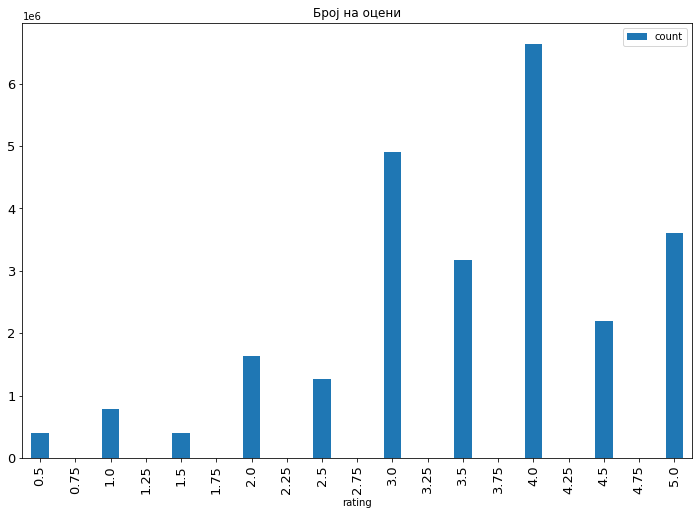

In [9]:
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Број на оцени',
    fontsize=13)

Можеме да видиме дека броевите меѓу основните (1, 1.5, 2, ...) од корисниците се релативно занемарливи. Односто тие се од корисниците кои имаа повеќе од еден рејтинг на истиот филм.  

Оценките за филмовите што не ги гледа корисникот стандардно се сметаат како 0. Ако се пресмета испаѓа многу голема бројка.

In [12]:
total_count = num_films * num_users
zero_count = total_count-refined_dataset.shape[0]
print(f"{zero_count:,}")

9,558,092,792


###  Исцртување на бројот на оцени за секој филм

In [8]:
movies_count_df = pd.DataFrame(refined_dataset.groupby('title').size(), columns=['count'])
movies_count_df.head()

,count
title,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",1
"""Great Performances"" Cats (1998)",179
#1 Cheerleader Camp (2010),9
#Captured (2017),2
#Female Pleasure (2018),3


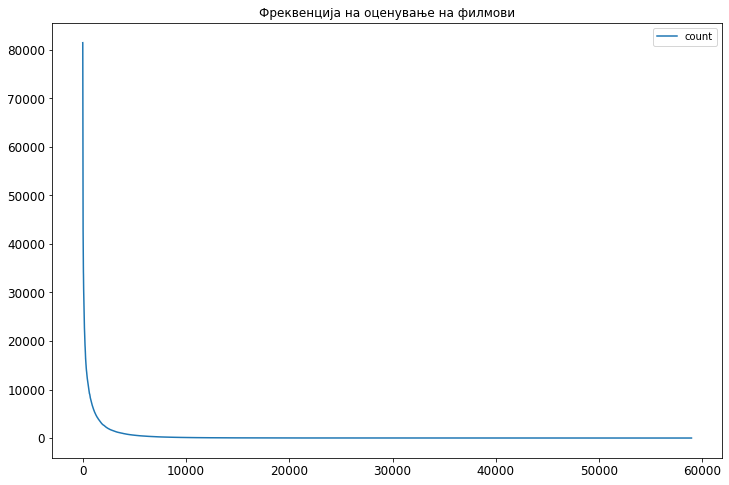

In [14]:
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Фреквенција на оценување на филмови',
        fontsize=12
    )

Бидејќи големината на базата на податоци избрана за овој проект е голема. Има потреба од отстранување на ретко оценети филмови или корисници кои дале оцена за помалку филмови.

Го гледаме својството на долга опашка, само мал дел од предметите се често оценети, така неречени популарни предмети. Огромното мнозинство на ставки ретко се оценуваат.

## Прочистување на податоците

### Исфрлање на филмови со малку рејтинзи

In [9]:
temp = movies_count_df[movies_count_df['count'] < 500] # pomalku od 10 rejtinzi
popular_movies_dataset = refined_dataset[~refined_dataset['title'].isin(temp["count"].keys())]

Ги тргаме непознатите филмови, но треба да се разгледа компромисот бидејќи многу филмови ќе се изгубат за минимален пад на оригиналното множество. 
Во мојот случај одбрав прагот да биде 500 оцени, каде испадна дека губиме скро 90 посто од филмовите, а новиот датасет има пад од 7 проценти што е многу малку. 
Како се зголемува прагот, имаме голем пад на можни филмови што е прилично лошо, но треба да има одреден праг бидејки за филмовите со мал број на оцени ќе имаме големи грешки при предикција. Исто така имаме и проблем со меморијата, додека се извршуваше стигна максимално и до 10Gb. 

In [10]:
(100*(len(temp)))/len(movies_count_df), (100*(len(refined_dataset)-len(popular_movies_dataset)))/len(refined_dataset)

(90.86468333389871, 6.912590122852926)

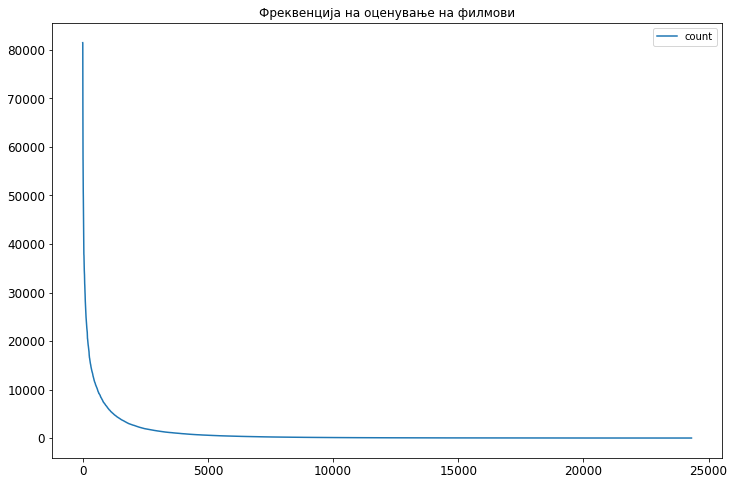

In [18]:
popular_movies_count_df = pd.DataFrame(popular_movies_dataset.groupby('title').size(), columns=['count'])
ax = popular_movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Фреквенција на оценување на филмови',
        fontsize=12
    )

### Исфрлање на корисници

In [19]:
user_count_df = pd.DataFrame(refined_dataset.groupby('userId').size(), columns=['count'])
user_count_df.sort_values('count',ascending=False)

,count
userId,
72315,32175
80974,9177
137293,8911
33844,7918
20055,7487
...,...
12094,20
119539,20
156759,20


In [11]:
user_count_df = pd.DataFrame(popular_movies_dataset.groupby('userId').size(), columns=['count'])
user_count_df.sort_values('count',ascending=False)

,count
userId,
72315,4694
57548,4247
20055,4038
80974,3818
33844,3784
...,...
103048,4
10861,4
122860,3


Кај корисниците имаме комплициран случај каде треба да трегнеме корисници и во двата екстреми. Ако се споредат оригиналната и новата датабаза со популарните филмови испага дека имаме ботови кои ги имаат оценето скоро сите филмови, најочигледно е кај најголемиот корисник. Мал процент од корисниците имаат многу оцени што реално не е физички способно да ги има изгледано сите филмови. Ако сметаме еден филм во просек е 2 сати, испага дека имаат гледано фкупно околу 2 години нонстоп.

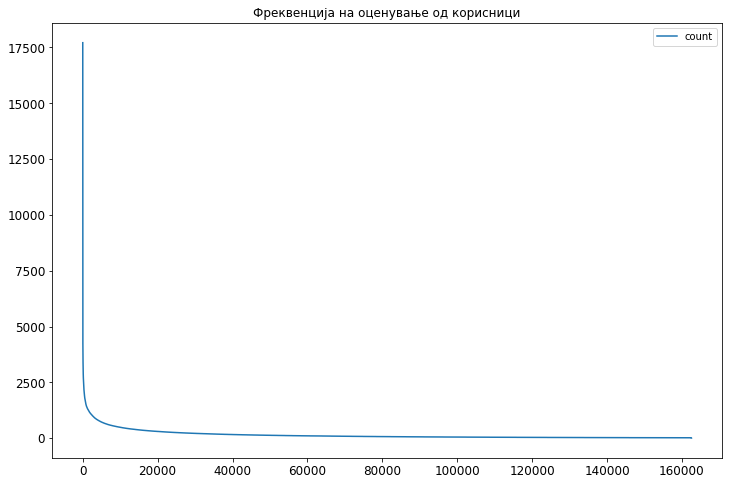

In [21]:
ax = user_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Фреквенција на оценување од корисници',
        fontsize=12
    )

In [12]:
temp = user_count_df[(user_count_df['count'] > 500) | (user_count_df['count'] < 40)]
final_dateset = popular_movies_dataset[~popular_movies_dataset.userId.isin(temp["count"].keys())]

За да добијам најдобра репрезентација на корисници:
1. Се тргаат корисниците кои имаат мал број на оцени, колку прагот е погоре толку повеке корисници се тргнати, но податочноот множество не се намалува исто како случајот со филмовите
2. Се тргаат корисниците со многу голем број на оцени кои преставуваат мал процент од корисниците, но податочното множество значително се намалува.

За најоптимални резлутати одбрав од опсег од 40 до 500 оцени по корисник каде произведе намалување на датасетот од 37 посто. Исто така имаме и подобрување на кривата каде долгата опашка е поблага.

In [13]:
(100*len(temp))/len(user_count_df), (100*(len(popular_movies_dataset)-len(final_dateset)))/len(popular_movies_dataset)

(34.96514682630015, 37.02568657957197)

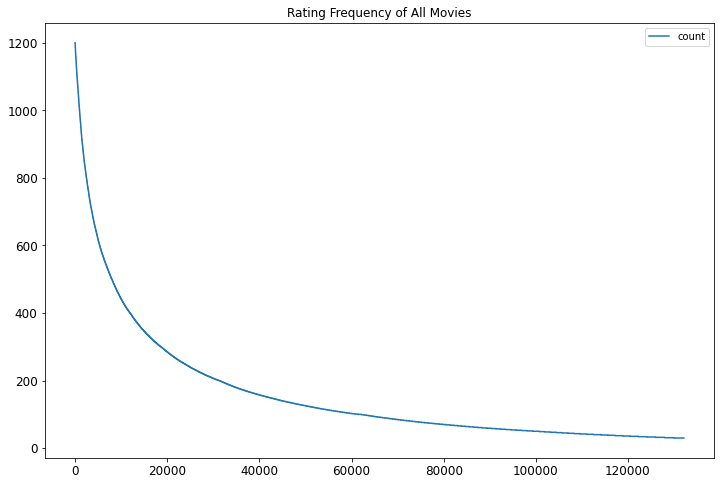

In [24]:
trimed_user_count_dfs = pd.DataFrame(final_dateset.groupby('userId').size(), columns=['count'])
ax = trimed_user_count_dfs \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )

In [16]:
import random
random.seed(100)
x = random.sample(range(1,len(final_dateset)), len(final_dateset)//3)
final_dateset = final_dateset.query('userId not in @x')
final_dateset.head()

,userId,title,rating
0,1,2046 (2004),4.5
2,1,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.5
3,1,Back to the Future Part II (1989),2.5
4,1,Back to the Future Part III (1990),2.5
5,1,Bad Education (La mala educación) (2004),4.0


Тргнавме и една третина корисници по случаен избор бидејќи имам моногу податоци за тренирање и многу време се троши да се тренира моделот.

## Споредба помеѓу податочните множества

In [14]:
print( 100*(num_users - len(final_dateset['userId'].value_counts()))/num_users, 
       100*(num_films - len(final_dateset['title'].value_counts()))/num_films, 
       100*(len(refined_dataset) - len(final_dateset))/len(refined_dataset))

34.965947053358846 90.86468333389871 41.37884274900692


При исфралање на 34% од корисниците и 90% од филмовите успеавме да остраниме 40% од датасетот, но треба да се направи компромис кој во мојот случај највеќе зависи до машината па затоа требаше драстично да се намали бројот на филмови и корисници.

## Тренирање на модел за ДНН

Кодирање на корисници и наслови на филмови за да се увериме дека секвенцата нема вредности што недостасуваат кога се работи со длабоки невронски мрежи.

In [18]:
user_enc = LabelEncoder()
final_dateset['user'] = user_enc.fit_transform(final_dateset['userId'].values)
n_users = final_dateset['user'].nunique()

In [19]:
item_enc = LabelEncoder()
final_dateset['movie'] = item_enc.fit_transform(final_dateset['title'].values)
n_movies = final_dateset['movie'].nunique()

In [20]:
final_dateset['rating'] = final_dateset['rating'].values.astype(np.float32)
min_rating = min(final_dateset['rating'])
max_rating = max(final_dateset['rating'])
n_users, n_movies, min_rating, max_rating

(70532, 5386, 0.5, 5.0)

In [30]:
final_dateset.head()

,userId,title,rating,user,movie
0,1,2046 (2004),4.5,0,166
1,1,5x2 (2004),3.5,0,302
2,1,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.5,0,1074
3,1,Back to the Future Part II (1989),2.5,0,1818
4,1,Back to the Future Part III (1990),2.5,0,1819


## Поделба на податоците на тренинг и тест 

In [21]:
X = final_dateset[['user', 'movie']].values
y = final_dateset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8798128, 2), (977570, 2), (8798128,), (977570,))

Колоните во влезната низа се поделени на две посебни низи. Бидејќи Керас ги смета за два различни влеза, секој влез треба да се внесе како сопствена низа. Исто така излезите со нормализираат.

In [23]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]
X_train, X_train_array

(array([[42918,  5093],
        [30517,  2694],
        [55916,  2993],
        ...,
        [ 4917,  3349],
        [47026,  2628],
        [ 8397,   227]], dtype=int64),
 [array([42918, 30517, 55916, ...,  4917, 47026,  8397], dtype=int64),
  array([5093, 2694, 2993, ..., 3349, 2628,  227], dtype=int64)])

In [24]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

## Градење на softmax длабока невронска мрежа

In [ ]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.embeddings.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.embeddings.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)

## Compiling the model
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


Како функционира овој DNN модел е, потребни се два влеза, кориснички ID и соодветни ID на филмови. Ембединг слојот ни овозможува да го претвориме секој збор во вектор со фиксна должина од дефинирана големина. Фиксната должина на зборовните вектори ни помага да ги претставиме зборовите на подобар начин заедно со намалените димензии. Овде моделот DNN се обидува да ги предвиди оцените на комбинацијата корисник - филм. Значи, можеме да внесеме специфичен кориснички ID и ID на невиден филм на корисникот и да очекуваме моделот да ги даде предвидените оценки на филмовите. Овде, оценките се веќе нормализирани и бидејќи потребно ни е кој невиден филм повеќе го интересира корисникот, оценките не се враќаат на скалата 0-5.

In [ ]:
model.summary()

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, 
    validation_data=(X_test_array, y_test),
    shuffle=True,callbacks=[reduce_lr])

In [ ]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
model.save('models/v1')

## Полнење на тежините

In [ ]:
model = keras.models.load_model('models/v1')

model.summary()

## Тестирање на моделот

In [141]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(final_dateset[final_dateset['user'] == user_id]['title']))
  print("")

  seen_movies = list(final_dateset[final_dateset['userId'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(final_dateset['movie']), max(final_dateset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray([user_id]*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

In [ ]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)

Најголем проблем за имплементација на DNN во мојот проект се ресурсите, многу време беше потребно да се истренира моделот бидејќи има многу параметри и податоци. Затоа извршував поголемо филтерирање на корисниците и филмовите за да се намали времето на тренирање, најтешко е погодување на тежините на ембединг слоевите.